# Assingment 2 - Contrast transfer
### Course: Convolutional Neural Networks with Applications in Medical Image Analysis

For the second assignment we will use the same dataset as before! Previously you have classified the available contrasts of the same anatomy, and for this assignment you will train an image to image model to generate one contrast from another. The task is to take T1-weighted images as inputs, and generate the corresponding T2-weighted images.

Your tasks, to include in the Jupyter notebook you hand in, are:
- Reach a validation MSE below 0.015 on the validation set, and describe what parameter combinations you have gone through to reach those results.
- Describe the effect of each hyper-parameter you have changed, and the way you have experimented with them. What problems did you face? What happened when the training failed? Try describing everything that you have learnt.
- Answer the questions set in notes

Upload the updated notebook to canvas, that also contains your answers to the questions above. The deadline for the assignment is March $30^{th}$, 15:00.

Good luck and have fun!

In [1]:
import os
import numpy as np
np.random.seed(2023)  # Set seed for reproducibility
import tensorflow as tf
import tensorflow.keras as keras
tf.random.set_seed(2026) # Note: Different to test different initializations.
!pip install tqdm # Adding tqdm to use progress bars. Unbarable waiting for each epoch to finish without feedback.
from tqdm import tqdm
# NOTE: The following imports were used to conduct hyperparameter tuning. If you want to use them, uncomment the lines and uncomment other sections in the code. Search for "TUNER CODE"
# !pip install keras-tuner # Adding keras tuner to use hyperparameter tuning.
# import keras_tuner as kt
# tf.config.set_visible_devices([], 'GPU') # Disable GPU to avoid memory issues. I had to do this to run it locally. I believe that i had the wrong CUDA version installed since GPU was really slow.
print(f"Tensorflow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")

Tensorflow version: 2.2.0
Keras version: 2.3.0-tf


2023-03-29 14:09:51.029490: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2023-03-29 14:09:51.062585: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-29 14:09:51.062757: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 3060 Ti computeCapability: 8.6
coreClock: 1.695GHz coreCount: 38 deviceMemorySize: 7.79GiB deviceMemoryBandwidth: 417.29GiB/s
2023-03-29 14:09:51.063975: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2023-03-29 14:09:51.089341: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-03-29 14:09:51.104198: I tensorflow/stream_executor/

## Visualization / Typing imports
I've imported some more visualization and typing libraries for ease of use.

In [2]:
# Using ImageGrid to plot the encodings.
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from typing import List

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if len(gpus) > 0:
    tf.config.experimental.set_memory_growth(gpus[0], True)
    print(f"GPU(s) available (using '{gpus[0].name}'). Training will be lightning fast!")
else:
    print("No GPU(s) available. Training will be suuuuper slow!")

# NOTE: These are the packages you will need for the assignment.
# NOTE: You are encouraged to use the course virtual environment, which already has GPU support.

GPU(s) available (using '/physical_device:GPU:0'). Training will be lightning fast!


## DataGenerator and Generator setup

In [4]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self,
                 data_path,
                 arrays,
                 batch_size=32,
                 ):

        self.data_path = data_path
        self.arrays = arrays
        self.batch_size = batch_size

        if data_path is None:
            raise ValueError('The data path is not defined.')

        if not os.path.isdir(data_path):
            raise ValueError('The data path is incorrectly defined.')

        self.file_idx = 0
        self.file_list = [self.data_path + '/' + s for s in
                          os.listdir(self.data_path)]
        
        self.on_epoch_end()
        with np.load(self.file_list[0]) as npzfile:
            self.in_dims = []
            self.n_channels = 1
            for i in range(len(self.arrays)):
                im = npzfile[self.arrays[i]]
                self.in_dims.append((self.batch_size,
                                    *np.shape(im),
                                    self.n_channels))
        self.n_batches = int(np.floor((len(self.file_list)) / self.batch_size))
    def __len__(self):
        """Get the number of batches per epoch."""
        return self.n_batches

    def __getitem__(self, index):
        """Generate one batch of data."""
        # Generate indexes of the batch
        indexes = self.indexes[index * self.batch_size:(index + 1) *
                               self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.file_list[k] for k in indexes]

        # Generate data
        a = self.__data_generation(list_IDs_temp)
        return a

    def on_epoch_end(self):
        """Update indexes after each epoch."""
        self.indexes = np.arange(len(self.file_list))
        np.random.shuffle(self.indexes)
    
    #@threadsafe_generator
    def __data_generation(self, temp_list):
        """Generate data containing batch_size samples."""
        # X : (n_samples, *dim, n_channels)
        # Initialization
        arrays = []

        for i in range(len(self.arrays)):
            arrays.append(np.empty(self.in_dims[i]).astype(np.single))

        for i, ID in enumerate(temp_list):
            with np.load(ID) as npzfile:
                for idx in range(len(self.arrays)):
                    x = npzfile[self.arrays[idx]] \
                        .astype(np.single)
                    x = np.expand_dims(x, axis=2)
                    x_max = np.max(x)
                    if x_max > 0:
                        x /= x_max
                    arrays[idx][i, ] = x
        return arrays

# NOTE: Don't change the data generator!

In [5]:
gen_dir = '../data/' # Change if you have copied the data locally on your machine 
array_labels = ['t1', 't2']  # Available arrays are: 't1', 't1ce', 't2', 'flair', 'mask'.
batch_size = 32

gen_train = DataGenerator(data_path=gen_dir + 'training',
                          arrays=array_labels,
                          batch_size=batch_size)

gen_val = DataGenerator(data_path=gen_dir + 'validating',
                        arrays=array_labels,
                        batch_size=batch_size)

gen_test = DataGenerator(data_path=gen_dir + 'testing',
                         arrays=array_labels,
                         batch_size=batch_size)

# NOTE: What arrays are you using? You can use multiple contrasts as inputs, if you'd like.
# NOTE: What batch size are you using? Should you use more? Or less?
# NOTE: Are you using the correct generators for the correct task? Training for training and validating for validating?

In [6]:
def plot_sample(x:np.ndarray,y:np.ndarray,n:int=3,title:str='Sample of inputs and labels')->tuple:
    """Plot a sample of the images and masks."""
    fig, ax = plt.subplots(2, n, figsize=(12, 5))
    for i in range(n):
        ax[0, i].imshow(x[i, :, :, 0], cmap='gray')
        ax[0, i].set_title('T1')
        ax[1, i].imshow(y[i, :, :, 0], cmap='gray')
        ax[1, i].set_title('T2')
        # Colorbar
        fig.colorbar(ax[0, i].imshow(x[i, :, :, 0], cmap='gray'), ax=ax[0, i])
        fig.colorbar(ax[1, i].imshow(y[i, :, :, 0], cmap='gray'), ax=ax[1, i])
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()
    return fig, ax

In [7]:
# A quick summary of the data:
print(f"Number of training images : {len(gen_train.file_list)}")
print(f"Training batch size       : {gen_train.in_dims}")

Number of training images : 8000
Training batch size       : [(32, 256, 256, 1), (32, 256, 256, 1)]


In [8]:
# Import packages important for building and training your model.
# import keras
from tensorflow.keras import backend as K
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Conv2D
from tensorflow.keras.layers import Flatten, Input
from tensorflow.keras.layers import MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Activation, concatenate
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout, UpSampling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, RMSprop, Nadam
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau, Callback

from tensorflow import Tensor
from tensorflow.keras.layers import Input, Conv2D, ReLU, BatchNormalization, \
                        Add, AveragePooling2D, Flatten, Dense, UpSampling2D
from tensorflow.keras.models import Model

In [9]:
def build_model():
    filt_size = 2
    input1 = Input(shape=(256, 256, 1))

    conv1 = Conv2D(filt_size, 3, activation='relu', padding='same', kernel_initializer='he_normal')(input1)
    conv1 = Conv2D(filt_size, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(filt_size * 2, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
    conv2 = Conv2D(filt_size * 2, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(filt_size * 4, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
    conv3 = Conv2D(filt_size * 4, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(filt_size * 8, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
    conv4 = Conv2D(filt_size * 8, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(filt_size * 16, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool4)
    conv5 = Conv2D(filt_size * 16, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(filt_size * 8, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2, 2))(drop5))
    merge6 = concatenate([drop4, up6], axis=3)
    conv6 = Conv2D(filt_size * 8, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge6)
    conv6 = Conv2D(filt_size * 8, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)

    up7 = Conv2D(filt_size * 4, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2, 2))(conv6))
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(filt_size * 4, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge7)
    conv7 = Conv2D(filt_size * 4, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)

    up8 = Conv2D(filt_size * 2, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2, 2))(conv7))
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(filt_size * 2, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge8)
    conv8 = Conv2D(filt_size * 2, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)

    up9 = Conv2D(filt_size, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2, 2))(conv8))
    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(filt_size, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge9)
    conv9 = Conv2D(filt_size, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation="exponential")(conv9)

    return Model(inputs=input1, outputs=conv10)
        

## Augmentation Class
I've implemented a set of classes used to augment the input training data. The implemented augmentations are: 
- **Flip**: Flips the image along the x or y axis
- **Rotate**: Rotates the image by a random angle.
- **Noise**: Adds random gaussian noise to the image.
- **Mask**: Masks a random number of sections of random size with zeros.
- **Translate**: Translates the image by a random number of pixels.
- **Shear**: Shears the image by a random angle.

Note: **Rotate**, **Shear** and **Translate** are implemented using the **Affine** transformation and are currently very slow. Therefore I have not used them.

In [10]:
# Augmentation class for used in the training pipeline.
from skimage.transform import rotate, AffineTransform, warp
# float wrapper for probability
def prob(p: float) -> bool:
    return np.random.random() < p
class Augmentation:
    verbose: bool = False
    # Parent class for all augmentations
    def __init__(self, p: float):
        self.p = p
    @property
    def name(self) -> str:
        return self.__class__.__name__
    def __call__(self, x: np.ndarray,y: np.ndarray) -> np.ndarray:
        if prob(self.p):
            if self.verbose:
                print(f"Augmenting: Applying {self.name}")
            return self.augment(x,y)
        else:
            return x,y
    def augment(self, x: np.ndarray,y:np.ndarray) -> np.ndarray:
        raise NotImplementedError
    

class Flip(Augmentation):
    def __init__(self, p: float = 0.5, axis: int = 0):
        super().__init__(p)
        self.axis = axis # 1 for horizontal, 0 for vertical
    def augment(self, x: np.ndarray,y:np.ndarray) -> np.ndarray:
        return np.flip(x, axis=self.axis),np.flip(y, axis=self.axis)

class Rotate(Augmentation):
    def __init__(self, p: float = 0.5, angle: float = np.pi/4):
        super().__init__(p)
        self.angle = angle
    def augment(self, x: np.ndarray,y:np.ndarray) -> np.ndarray:
        # Rotate image and fill with zeros
        # Random angle between -angle and angle
        angle = np.random.uniform(-self.angle, self.angle)
        # Batched rotate
        return np.array([rotate(img, angle, resize=False, mode="constant", cval=0) for img in x]),np.array([rotate(img, angle, resize=False, mode="constant", cval=0) for img in y])
class Noise(Augmentation):
    def __init__(self, p: float = 0.5, mean: float = 0.0, std: float = 0.1):
        super().__init__(p)
        self.mean = mean
        self.std = std
    def augment(self, x: np.ndarray,y:np.ndarray) -> np.ndarray:
        noise = np.random.normal(self.mean, self.std, x.shape)
        return (x + noise, y)

class Mask(Augmentation):
    def __init__(self, p: float = 0.5, max_n_masks: int = 10, mask_size: float = 0.5):
        super().__init__(p)
        self.max_n_masks = max_n_masks
        self.mask_size = mask_size
    def augment(self, x: np.ndarray, y:np.ndarray) -> np.ndarray:
        # Random number of masks
        n_masks = np.random.randint(1, self.max_n_masks)
        w = x.shape[-3]
        h = x.shape[-2]
        for _ in range(n_masks):
            # Random mask size
            mask_size = np.random.uniform(low=self.mask_size/2, high=self.mask_size)
            # Random mask position
            x1 = np.random.randint(0, w)
            y1 = np.random.randint(0, h)
            x2 = int(x1 + w * mask_size)
            y2 = int(y1 + h * mask_size)
            x[:, x1:x2, y1:y2,:] = 0
        return (x, y)

class Translate(Augmentation):
    def __init__(self, p: float = 0.5, factor: float = 0.5):
        super().__init__(p)
        self.factor = factor
    def augment(self, x: np.ndarray,y:np.ndarray) -> np.ndarray:
        # Random translation factor
        tx = np.random.uniform(-self.factor, self.factor) * x.shape[0]
        ty = np.random.uniform(-self.factor, self.factor) * x.shape[1]
        # Affine transform, grayscale image so no need to transform channels
        tform = AffineTransform(translation=(tx, ty))
        # Apply transform, Image will be filled with zeros
        x = np.array([warp(img, tform.inverse, mode="constant", cval=0) for img in x])
        y = np.array([warp(img, tform.inverse, mode="constant", cval=0) for img in y])
        return x,y

class Shear(Augmentation):
    def __init__(self, p: float = 0.5, factor: float = 0.5):
        super().__init__(p)
        self.factor = factor
    def augment(self, x: np.ndarray,y:np.ndarray) -> np.ndarray:
        # Random shear factor
        shear_factor = np.random.uniform(-self.factor, self.factor)
        # Create affine transform
        tform = AffineTransform(shear=shear_factor)
        # Use warp to apply transform
        x = np.array([warp(img, tform.inverse, mode="constant", cval=0) for img in x])
        y = np.array([warp(img, tform.inverse, mode="constant", cval=0) for img in y])
        return x,y
class Augmentor:
    """
    Augmentations:
    flip_x: float
        Probability of flipping the image horizontally
    flip_y: float
        Probability of flipping the image vertically
    rotate: float
        Probability of rotating the image
    radians: float
        Maximum rotation angle in radians
    translate: float
        Probability of translating the image
    noise: float
        Probability of adding noise to the image
    noise_std: float
        Standard deviation of the noise
    noise_mean: float
        Mean of the noise
    mask: float
        Probability of masking the image
    max_n_masks: int
        Maximum number of masks
    mask_size: float
        Maximum size of the mask as a fraction of the image size
    shear: float
        Probability of shearing the image
    shear_factor: float
        Maximum shear factor
    """
    def __init__(self,
                flip_x:float=0.25,
                flip_y:float=0.25,
                rotate:float=0.5,
                radians:float=np.pi/6,
                translate:float=0.2,
                noise:float=0.25,
                noise_std:float=0.1,
                noise_mean:float=0.1,
                mask:float=0.8,
                max_n_masks:int=10,
                mask_size:float=0.25,
                shear:float=0.1,
                shear_factor:float=0.4,
                verbose:bool=False
                ):
        self.verbose = verbose
        self._active = True
        Augmentation.verbose = self.verbose
        self.augmentations = {}
        if noise > 0:
            self.augmentations["noise"] = Noise(p=noise, std=noise_std, mean=noise_mean)
        if flip_x > 0:
            self.augmentations["flip_x"] = Flip(p=flip_x, axis=1)
        if flip_y > 0:
            self.augmentations["flip_y"] = Flip(p=flip_y, axis=0)
        if rotate > 0:
            self.augmentations["rotate"] = Rotate(p=rotate, angle=radians)
        if translate > 0:
            self.augmentations["translate"] = Translate(p=translate, factor=translate)
        if mask > 0:
            self.augmentations["mask"] = Mask(p=mask, max_n_masks=max_n_masks, mask_size=mask_size)
        if shear > 0:
            self.augmentations.append(Shear(p=shear, factor=shear_factor))
    def __call__(self, x: np.ndarray,y:np.ndarray) -> np.ndarray:
        if self._active:
            if x.shape != y.shape:
                raise Exception("x and y must have the same shape")
            if len(x.shape) < 4:
                x = x[np.newaxis,...]
                y = y[np.newaxis,...]
            for aug in self.augmentations.values():
                x,y = aug(x,y)
        return x, y
    @property
    def keys(self):
        return list(self.augmentations.keys())
    @property
    def active(self):
        return self._active
    def scale_probability(self, key:str, factor:float):
        if self.verbose:
            print(f"Scaling probability of {key} by {factor:3.3e}: {self.augmentations[key].p:3.3e} -> {self.augmentations[key].p * factor:3.3e}")
        self.augmentations[key].p *= factor
    def set_active(self, active:bool):
        self._active = active
    def __repr__(self):
        return f"Augmentor({', '.join([f'{k}: {v.p:3.3e}' for k,v in self.augmentations.items()])})"

## Augmentation DataGenerator subclass
In order to apply augmentation to the images using model.fit I've implemented a subclass of DataGenerator that applies the augmentation to the images before returning them.

In [11]:

class DataGeneratorAugmented(DataGenerator):
    def __init__(self, *args, augmentor:Augmentor=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.augmentor = augmentor
    def __getitem__(self, index):
        x, y = super().__getitem__(index)
        if self.augmentor is not None:
            x, y = self.augmentor(x, y)
        return x, y
    

## Custom Callbacks
Created a custom callback to save images from the validation set after each epoch. This is useful for visualizing the progress of the model, and to see if the model exhibits mode collapse, overfitting, etc.


In [12]:
def save_image(x, y, pred, path,n=2):
    # Save high resolution image
    x = np.squeeze(x)
    y = np.squeeze(y)
    pred = np.squeeze(pred)
    fig, ax = plt.subplots(3, n, figsize=(n*5,15), dpi=300)
    for i in range(n):
        ax[0,i].imshow(x[i], cmap="gray")
        ax[0,i].set_title("Input")
        ax[1,i].imshow(y[i], cmap="gray")
        ax[1,i].set_title("Label")
        ax[2,i].imshow(pred[i], cmap="gray")
        ax[2,i].set_title("Prediction")
        ax[0,i].axis("off")
        ax[1,i].axis("off")
        ax[2,i].axis("off")
    fig.tight_layout()
    plt.savefig(path)
    plt.close()
class SaveImage(Callback):
    def __init__(self, path:str,data:DataGenerator,freq:int=1, verbose:bool=False,**kwargs):
        super().__init__(**kwargs)
        self.path = path
        self.freq = freq
        self.verbose = verbose
        self.data = data
    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.freq == 0:
            name = f"epoch_{epoch:03d}.png"
            path = self.path+name
            idx = np.random.randint(0, len(self.data))
            x, y = self.data[idx]
            pred = self.model.predict(x)
            if self.verbose:
                print(f"Saving image to {path}")
            save_image(x, y, pred, path,3)

## Training Setup - Hyperparameters
Setting up hyperparameters for training along with hyperparameter tuning module.

In [13]:
# Model parameters
W,H,C = 256,256,1
input_shape = (W,H,C)
num_classes = C # Number of classes is equal to the number of channels in the output
# Define the hyper parameters which will be tuned.
# Model Parameters
filters = [2**i for i in range(1,4)]
activations = ["relu","selu","gelu","tanh"]
drop_rates = [0.0,0.05,0.1,0.2]
output_activation = "softmax"
batch_norm = [True,False]
# Training Parameters
learning_rates = [1e-2,5e-3,1e-3,5e-4]
weight_decay = [1e-2,1e-3,1e-4,0.0]
clipnorm = [2.0,1.0,0.5,0.1]
optimizers = ["Adam","RMSprop","Nadam"]
str2optimizer = {"Adam":Adam,"RMSprop":RMSprop,"Nadam":Nadam}
# Fixed Parameters
max_epochs = 50
output_activation = "exponential" # Our regression values are between 0 and 1, hence -> sigmoid.
loss = "mse"
# Project Parameters
project_name = "Unet_final"
project_dir = "./theodorjonsson_tuner/"
model_path = os.path.join(project_dir,project_name,"model/")
if not os.path.exists(model_path):
    os.makedirs(model_path)
# Model Training Callbacks
early_stop = EarlyStopping(monitor="val_loss",patience=6,restore_best_weights=True) # Early stopping to avoid overfitting
reduce_lr = ReduceLROnPlateau(monitor="val_loss",patience=3,factor=0.5,min_lr=1e-6) # Learning rate scheduler
image_save = SaveImage(model_path,data=gen_val,freq=1,verbose=True) # Save an image of the input and output of the network.
model_callbacks = [early_stop,reduce_lr,image_save] # List of callbacks to use during training.
# Augmentator
augmentor = Augmentor(translate=0, # No translation. Due to lack of speed.
                      shear=0, # No shear. Due to lack of speed.
                      rotate=0, # No rotation. Due to lack of speed.
                      mask=0.8, # Probability of masking the image.
                      mask_size=0.2, # Maximum size of the mask as a fraction of the image size.
                      max_n_masks=8, # Maximum number of masks to apply.
                      noise=0.4, # Probability of adding Gaussian noise to the image.
                      noise_mean=0.05, # Mean of the noise.
                      noise_std=0.1, # Standard deviation of the noise.
                      ) # Augmentation of the data.
# Redefine the training data generator to use the augmentor.
gen_train = DataGeneratorAugmented(data_path=gen_dir + 'training',
                          arrays=array_labels,
                          batch_size=batch_size,
                          augmentor=augmentor)


## Model Build Function
Function used to build and compile the model used for hyperparameter tuning on the training set.
\
This function uses the hyperparameters in the code section above. The function can also use a dictionary of hyperparamters to override the tuning parameters.

In [14]:

def build_model_hp(hp:"kt.HyperParameters",hyperparameters:dict=None):
    input1 = Input(shape=input_shape)
    # Tuning Parameters
    if not hyperparameters:
        hp_learning_rate = hp.Choice("learning_rate",values=learning_rates)
        hp_weight_decay = hp.Choice("weight_decay",values=weight_decay)
        hp_clipnorm = hp.Choice("clipnorm",values=clipnorm)
        hp_optimizer = str2optimizer[hp.Choice("optimizer",values=optimizers)]
        optimizer = hp_optimizer(learning_rate=hp_learning_rate,
                                clipnorm=hp_clipnorm,
                                decay=hp_weight_decay)
        # Model Parameters
        hp_filter = hp.Choice("filters",values=filters)
        hp_activation = hp.Choice("activation",values=activations)
        hp_drop_rate_encoder = hp.Choice("drop_rate_encoder",values=drop_rates)
        hp_drop_rate_decoder = hp.Choice("drop_rate_decoder",values=drop_rates)
        hp_batch_norm = hp.Choice("batch_norm",values=batch_norm)
    else: # If hyperparameters are given, use them instead of the hp object which is used for tuning.
        assert isinstance(hyperparameters,dict), "hyperparameters must be a dictionary."
        hp_learning_rate = hyperparameters["learning_rate"]
        hp_weight_decay = hyperparameters["weight_decay"]
        hp_clipnorm = hyperparameters["clipnorm"]
        hp_optimizer = str2optimizer[hyperparameters["optimizer"]]
        optimizer = hp_optimizer(learning_rate=hp_learning_rate,
                                clipnorm=hp_clipnorm,
                                decay=hp_weight_decay)
        # Model Parameters
        hp_filter = hyperparameters["filters"]
        hp_activation = hyperparameters["activation"]
        hp_drop_rate_encoder = hyperparameters["drop_rate_encoder"]
        hp_drop_rate_decoder = hyperparameters["drop_rate_decoder"]
        hp_batch_norm = hyperparameters["batch_norm"]
    # Layer 1
    conv1 = Conv2D(hp_filter, 3, activation=hp_activation, padding='same', kernel_initializer='he_normal')(input1)
    if hp_batch_norm:
        conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(hp_filter, 3, activation=hp_activation, padding='same', kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    # Layer 2
    conv2 = Conv2D(hp_filter * 2, 3, activation=hp_activation, padding='same', kernel_initializer='he_normal')(pool1)
    if hp_batch_norm:
        conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(hp_filter * 2, 3, activation=hp_activation, padding='same', kernel_initializer='he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    # Layer 3
    conv3 = Conv2D(hp_filter * 4, 3, activation=hp_activation, padding='same', kernel_initializer='he_normal')(pool2)
    if hp_batch_norm:
        conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(hp_filter * 4, 3, activation=hp_activation, padding='same', kernel_initializer='he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    # Layer 4
    conv4 = Conv2D(hp_filter * 8, 3, activation=hp_activation, padding='same', kernel_initializer='he_normal')(pool3)
    if hp_batch_norm:
        conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(hp_filter * 8, 3, activation=hp_activation, padding='same', kernel_initializer='he_normal')(conv4)
    drop4 = Dropout(hp_drop_rate_encoder)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)
    # Layer 5 Bottle Neck
    conv5 = Conv2D(hp_filter * 16, 3, activation=hp_activation, padding='same', kernel_initializer='he_normal')(pool4)
    if hp_batch_norm:
        conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(hp_filter * 16, 3, activation=hp_activation, padding='same', kernel_initializer='he_normal')(conv5)
    drop5 = Dropout(hp_drop_rate_encoder)(conv5)
    # Layer 6 Decoder with skip connection
    up6 = Conv2D(hp_filter * 8, 2, activation=hp_activation, padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2, 2))(drop5))
    merge6 = concatenate([drop4, up6], axis=3)
    conv6 = Conv2D(hp_filter * 8, 3, activation=hp_activation, padding='same', kernel_initializer='he_normal')(merge6)
    if hp_batch_norm:
        conv6 = BatchNormalization()(conv6)
    conv6 = Dropout(hp_drop_rate_decoder)(conv6)
    conv6 = Conv2D(hp_filter * 8, 3, activation=hp_activation, padding='same', kernel_initializer='he_normal')(conv6)
    # Layer 7
    up7 = Conv2D(hp_filter * 4, 2, activation=hp_activation, padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2, 2))(conv6))
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(hp_filter * 4, 3, activation=hp_activation, padding='same', kernel_initializer='he_normal')(merge7)
    if hp_batch_norm:
        conv7 = BatchNormalization()(conv7)
    conv7 = Dropout(hp_drop_rate_decoder)(conv7)
    conv7 = Conv2D(hp_filter * 4, 3, activation=hp_activation, padding='same', kernel_initializer='he_normal')(conv7)
    # Layer 8
    up8 = Conv2D(hp_filter * 2, 2, activation=hp_activation, padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2, 2))(conv7))
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(hp_filter * 2, 3, activation=hp_activation, padding='same', kernel_initializer='he_normal')(merge8)
    if hp_batch_norm:
        conv8 = BatchNormalization()(conv8)
    conv8 = Conv2D(hp_filter * 2, 3, activation=hp_activation, padding='same', kernel_initializer='he_normal')(conv8)
    # Layer 9
    up9 = Conv2D(hp_filter, 2, activation=hp_activation, padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2, 2))(conv8))
    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(hp_filter, 3, activation=hp_activation, padding='same', kernel_initializer='he_normal')(merge9)
    if hp_batch_norm:
        conv9 = BatchNormalization()(conv9)
    conv9 = Conv2D(hp_filter, 3, activation=hp_activation, padding='same', kernel_initializer='he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation=hp_activation, padding='same', kernel_initializer='he_normal')(conv9)
    conv10 = Conv2D(C, 1, activation=output_activation)(conv9)

    model = Model(inputs=input1, outputs=conv10)
    model.compile(optimizer=optimizer, loss=loss)
    return model
# # NOTE: The following code would set up the tuner for hyperparameter search.
# # Create the tuner to search for the best hyperparameters
# # ----TUNER CODE----
# tuner = kt.Hyperband(
#     build_model_hp,
#     objective='val_loss',
#     max_epochs=max_epochs,
#     directory=project_dir,
#     project_name=project_name,
#     factor=6,
#     seed=0,
# )
# # ------------------

## Hyperparameter Tuning
Tune for the best hyperparameters for the model. This was done using a smaller number of epochs per model to save time.
I've also added early stopping per model to save time such that it is not necessary to run all epochs for each model.
Each set of hyperparameters is saved in a separate folder along the achieved validation loss.

The search space for the hyperparameters is as follows:

| Hyperparmeter       |               |                   |                |                    |
|---------------------|---------------|-------------------|----------------|--------------------|
| Optimizer           | Adam          | RMSprop           | Nadam          |                    |
| Learning rate       | $ 10 ^{- 2 }$ | $ 5 \cdot 10 ^{- 3 }$ | $  10 ^{- 3 }$ | $  5 \cdot 10 ^{- 4 }$ |
| Weight Decay        | $ 10 ^{- 2 }$ | $ 10 ^{- 3 }$     | $ 10 ^{- 4 }$  | $0.0$      |
| Filters             | $ 2 $         | $ 4$              | $  8$ |  |
| Clip norm           | $ 2.0 $         | $ 1.0 $             | $0.5$          | $0.1$              |
| Batch Normalization | True          | False             |                |                    |
| Drop rate Encoder   | $0.0$         | $0.05$            | $0.1$          | $0.2$              |
| Drop rate Decoder   | $0.0$         | $0.05$            | $0.1$          | $0.2$              |
| Activation          | ReLU          | SeLU              | GeLU           | Tanh               |

### Hyperparameter Tuning Algorithm
The algorithm used for hyperparameter tuning was hyperband search. This algorithm combines random search with successive halving. Successive halving utilizes the fact that the best hyperparameters for a model are often better in the beginning relative to worse hyperparameter configurations. With this being known we can train a model with each configuration a small number of epochs. This if often refered to as allocating a small budget for each configuration. First a large number of configurations are sampled and placed into different groups. When all configurations in a group have been trained for the same number of epochs, the worst performing configurations are removed from the group. This is done for each group. When all groups have been trained and reduced to the best performing configurations, the best performing configuration are then batched into new groups and trained again vs each other. This is repeated until only one configuration remains. This configuration is then trained for a large number of epochs to get the best possible model.

This algorithm is very efficient as it only trains a small number of epochs for each configuration. This is done to save time and resources.
The algorithm is described in more detail in the paper [HYPERBAND: BANDIT-BASED CONFIGURATION EVALUATION FOR HYPERPARAMETER OPTIMIZATION](https://openreview.net/pdf?id=ry18Ww5ee).

In [15]:
# # NOTE: This is the code to search for the best hyperparameters. 
# #       It is commented out because Tommy advised me to only supply the best hyperparameters to the model.
# ----TUNER CODE----
# tuner.search(gen_train, validation_data=gen_val, epochs=max_epochs, callbacks=[early_stop,reduce_lr])
# ------------------

## Hyperparameter Tuning Results
The results of the hyperparameter tuning are highlighted in green in the table below.

| Hyperparmeter       |               |                   |                |                    |
|---------------------|---------------|-------------------|----------------|--------------------|
| Optimizer           | $\color{gray}{\text{Adam}}$          | $\color{gray}{\text{RMSprop}}$           | $\color{white}{\text{Nadam}}$          |                    |
| Learning rate       | $\color{white}{10^{-2}}$ | $\color{gray}{5 \cdot 10 ^{- 3 }}$ | $\color{gray}{10 ^{- 3 }}$ | $\color{gray}{5 \cdot 10 ^{- 4 }}$ |
| Weight Decay        | $\color{gray}{10 ^{- 2 }}$|$\color{gray}{ 10 ^{- 3 }}$ | $\color{white}{10^{-4}}$  |$\color{gray}{0.0}$      |
| Filters             | $\color{gray}{2}$ | $\color{gray}{4}$ | $\color{white}{8}$ |  |
| Clip norm           | $\color{white}{2.0}$         | $\color{gray}{1.0}$             | $\color{gray}{0.5}$          | $\color{gray}{0.1}$              |
| Batch Normalization | $\color{white}{\text{True}}$          |$\color{gray}{\text{False}}$             |                |                    |
| Drop rate Encoder   | $\color{white}{0.0}$         | $\color{gray}{0.05}$            | $\color{gray}{0.1}$          | $\color{gray}{0.2}$              |
| Drop rate Decoder   | $\color{gray}{0.0}$         | $\color{white}{0.05}$            | $\color{gray}{0.1}$          | $\color{gray}{0.2}$              |
| Activation          | $\color{gray}{\text{ReLU}}$          | $\color{white}{\text{SeLU}}$              |$\color{gray}{\text{GeLU}}$           |$\color{gray}{\text{Tanh}}$               |


In [16]:

# # NOTE: Code used for retrieving the best tuned hyperparameters and model.
# # Retrieve the best hyperparameters and initialize the model for training.

# ----TUNER CODE----
# hyps = tuner.get_best_hyperparameters(num_trials=1)[0]
# model:Model = tuner.get_best_models(num_models=1)[0]
# print(f"Best hyperparameters by tuning:")
# for k,v in hyps.values.items():
#     if not k.startswith("tuner"):
#         print(f"{k}: {v}")
# model.evaluate(gen_test)
# ------------------

## Applying the best hyperparameters
Using the best hyperparameters from the hyperparameter tuning to train a final model to test on the test set.

In [17]:
hyps = {'learning_rate': 0.01,
        'weight_decay': 0.0001,
        'clipnorm': 2.0,
        'optimizer': 'Nadam',
        'filters': 8,
        'activation': 'selu',
        'drop_rate_encoder': 0.0, 
        'drop_rate_decoder': 0.05, 
        'batch_norm': True}
model = build_model_hp(hp=None,hyperparameters=hyps)
model.summary()

2023-03-29 14:10:23.063826: I tensorflow/core/platform/cpu_feature_guard.cc:143] Your CPU supports instructions that this TensorFlow binary was not compiled to use: SSE4.1 SSE4.2 AVX AVX2 FMA
2023-03-29 14:10:23.093446: I tensorflow/core/platform/profile_utils/cpu_utils.cc:102] CPU Frequency: 4099895000 Hz
2023-03-29 14:10:23.094068: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x27b5650 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2023-03-29 14:10:23.094081: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2023-03-29 14:10:23.095739: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1102] Device interconnect StreamExecutor with strength 1 edge matrix:
2023-03-29 14:10:23.095754: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1108]      


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 8)  80          input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 8)  32          conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 8)  584         batch_normalization[0][0]        
______________________________________________________________________________________________

In [18]:

def plot(save:bool=False):
    x_train, y_train = gen_train[0]
    x_val, y_val = gen_val[0]
    plot_sample(x_train, y_train,title="Augmented samples")
    plot_sample(x_val, y_val,title="Validation samples")
    # Plot initial predictions.
    pred = model(x_val)
    plot_sample(x_val, pred,title="Predictions")
    if save:
        save_image(x_val,y_val,pred,path="./image.png")

## Training the final model
Training the final model using model.fit with the best hyperparameters from the hyperparameter tuning and the augmentation data generator.\
The training was done using a batch size of 32 and 50 epochs and a learning rate scheduler which halves the learning rate upon stagnation of the validation loss.

In [19]:
# Train the model for a longer period of time using the best hyperparameters found during the "search" phase.
history = model.fit(gen_train, validation_data=gen_val, epochs=max_epochs, callbacks=model_callbacks)
# NOTE: Plotting the losses helps a lot.
# NOTE: What does plotting the training data tell you? Should you plot something else?
# NOTE: What should one do with the validation data? The data generator has a 'validation_data' argument as well.
# NOTE: When should one stop? Did you overtrain? Did you train for long enough?
# NOTE: Think abouct implementing Early Stopping?

Epoch 1/50


2023-03-29 13:22:24.347254: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout_2/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-03-29 13:22:25.736097: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2023-03-29 13:22:26.943939: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-03-29 13:22:28.532140: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


1/1 [==============================] - 0s 211ms/step loss: 0.76
Saving image to ./theodorjonsson_tuner/Unet_final/model/epoch_000.png
250/250 [==============================] - 52s 173ms/step - loss: 0.7642 - val_loss: 0.0059 - lr: 0.0100
Epoch 2/50
  1/250 [..............................] - ETA: 58s - loss: 0.0092

/tmp/ipykernel_29104/2521157187.py:62: RuntimeWarning: overflow encountered in cast
  arrays.append(np.empty(self.in_dims[i]).astype(np.single))


1/1 [==============================] - 0s 23ms/step- loss: 0.00
Saving image to ./theodorjonsson_tuner/Unet_final/model/epoch_001.png
250/250 [==============================] - 42s 169ms/step - loss: 0.0075 - val_loss: 0.0209 - lr: 0.0100
Epoch 3/50
1/1 [==============================] - 0s 22ms/step- loss: 0.00
Saving image to ./theodorjonsson_tuner/Unet_final/model/epoch_002.png
250/250 [==============================] - 42s 169ms/step - loss: 0.0065 - val_loss: 0.0052 - lr: 0.0100
Epoch 4/50
1/1 [==============================] - 0s 25ms/step- loss: 0.00
Saving image to ./theodorjonsson_tuner/Unet_final/model/epoch_003.png
250/250 [==============================] - 42s 169ms/step - loss: 0.0059 - val_loss: 0.0049 - lr: 0.0100
Epoch 5/50
1/1 [==============================] - 0s 22ms/step- loss: 0.00


/tmp/ipykernel_29104/2521157187.py:62: RuntimeWarning: invalid value encountered in cast
  arrays.append(np.empty(self.in_dims[i]).astype(np.single))


Saving image to ./theodorjonsson_tuner/Unet_final/model/epoch_004.png
250/250 [==============================] - 41s 164ms/step - loss: 0.0058 - val_loss: 0.0049 - lr: 0.0100
Epoch 6/50
1/1 [==============================] - 0s 24ms/step- loss: 0.00
Saving image to ./theodorjonsson_tuner/Unet_final/model/epoch_005.png
250/250 [==============================] - 43s 170ms/step - loss: 0.0060 - val_loss: 0.0048 - lr: 0.0100
Epoch 7/50
1/1 [==============================] - 0s 25ms/step- loss: 0.00
Saving image to ./theodorjonsson_tuner/Unet_final/model/epoch_006.png
250/250 [==============================] - 43s 170ms/step - loss: 0.0052 - val_loss: 0.0049 - lr: 0.0100
Epoch 8/50
1/1 [==============================] - 0s 23ms/step- loss: 0.00
Saving image to ./theodorjonsson_tuner/Unet_final/model/epoch_007.png
250/250 [==============================] - 43s 170ms/step - loss: 0.0048 - val_loss: 0.0047 - lr: 0.0050
Epoch 9/50
1/1 [==============================] - 0s 24ms/step- loss: 0.00


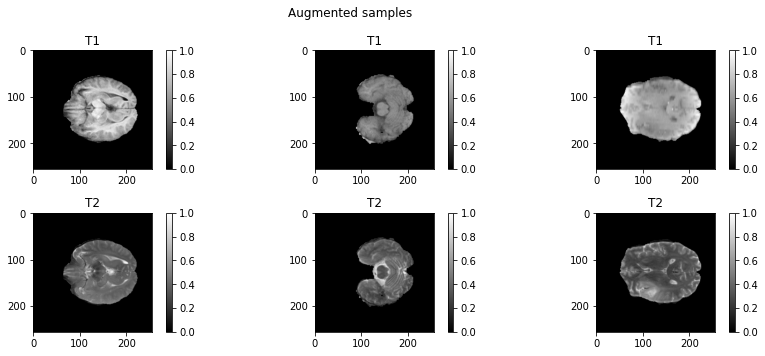

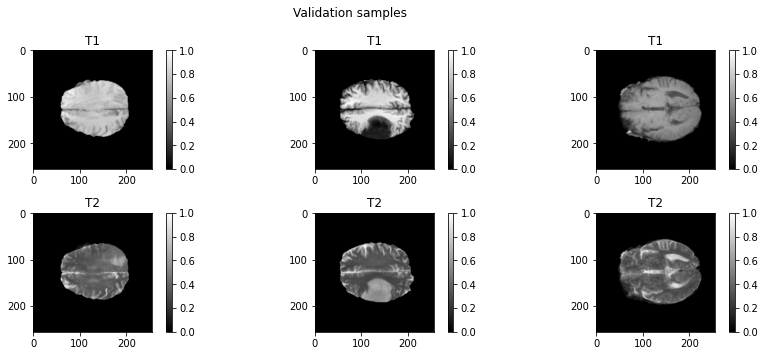

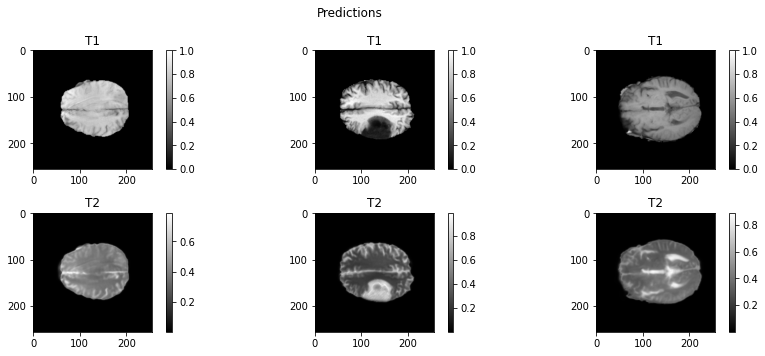

In [20]:
plot()

In [27]:
# Evaluate the model on the test set.
test_err = model.evaluate(gen_test)
val_err = model.evaluate(gen_val)
print(f"Test error: {test_err}")
print(f"Validation error: {val_err}")

 4/31 [==>...........................] - ETA: 1s - loss: 0.0040

/tmp/ipykernel_29104/2521157187.py:62: RuntimeWarning: overflow encountered in cast
  arrays.append(np.empty(self.in_dims[i]).astype(np.single))


31/31 [==============================] - 1s 37ms/step - loss: 0.0032
Test error: 0.003927041310817003
Validation error: 0.0031514978036284447


In [26]:
# Since the initial loss is very high (due to the random initialization and the exponential output activation function), we start plotting from the second epoch.
plt.plot(history.history['loss'][2:], label='train')
plt.plot(history.history['val_loss'][2:], label='val')
plt.title('Loss')
plt.legend()
plt.show()

1/1 [==============================] - 0s 16ms/step


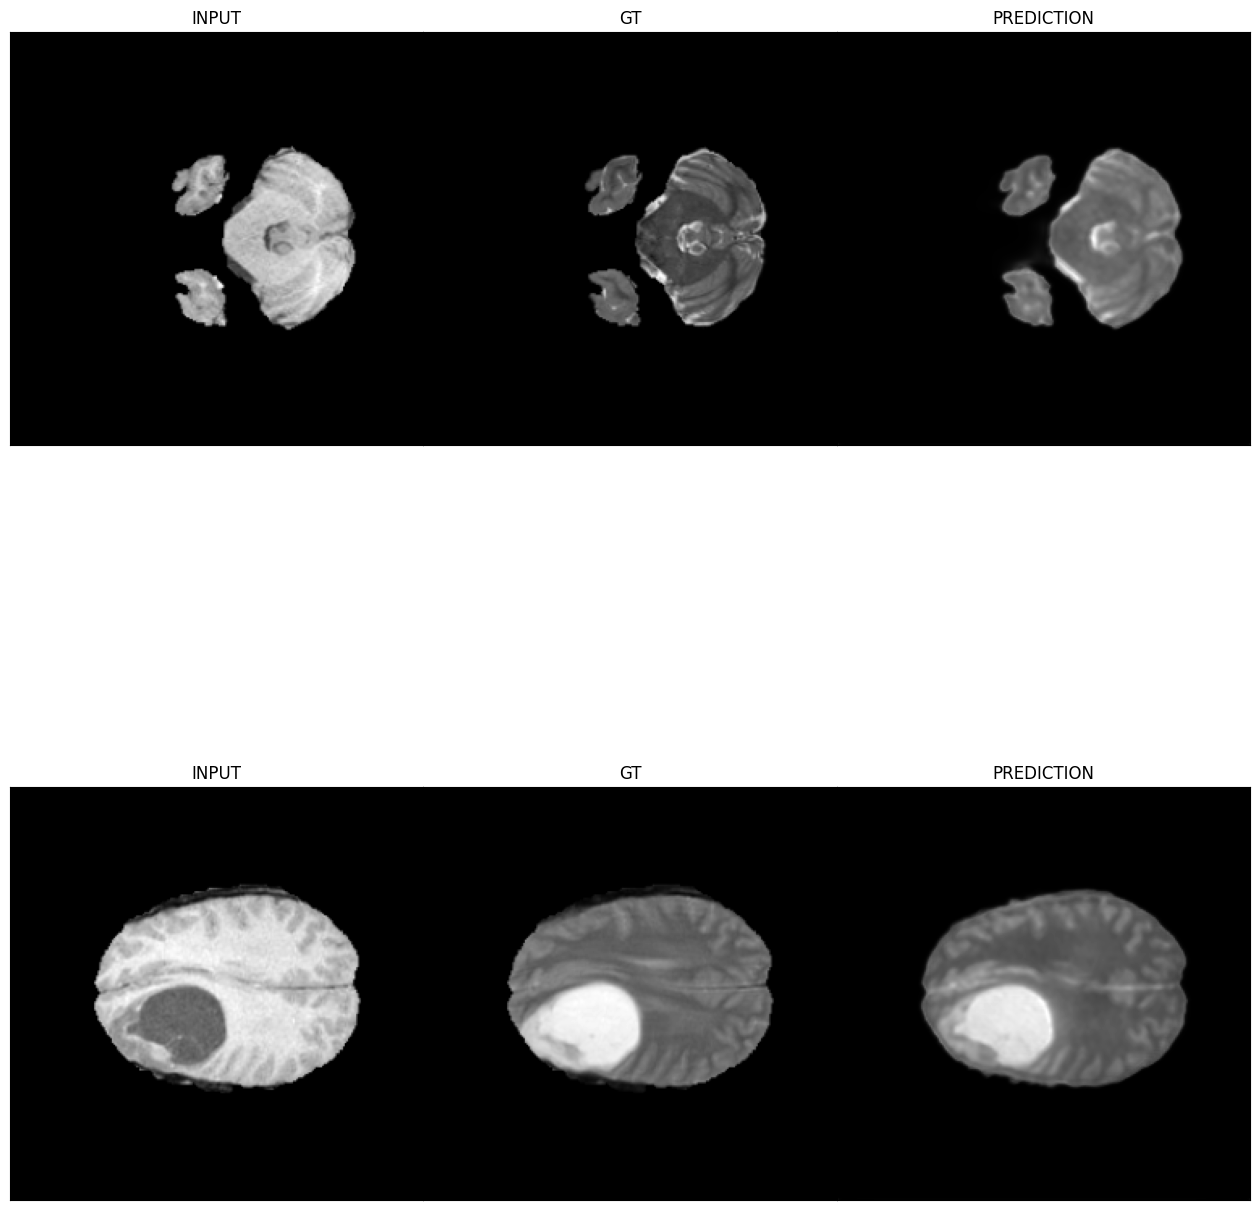

In [61]:
def test_model(model: Model, gen_data: DataGenerator,n: int = batch_size,augmentor: Augmentor = None):
    t1, t2 = gen_data[np.random.randint(0, len(gen_data))]
    if augmentor is not None:
        t1, t2 = augmentor(t1, t2)
    prediction = model.predict(t1)
    cols = 3
    fig, ax = plt.subplots(n,3,figsize=(16, 10*n), dpi=100)
    for idx in range(n):
        ax[idx, 0].imshow(t1[idx, :, :], cmap='gray')
        ax[idx,0].set_title('INPUT')
        ax[idx,0].set_xticks([])
        ax[idx,0].set_yticks([])
        ax[idx,1].imshow(t2[idx, :, :], cmap='gray')
        ax[idx,1].set_title('GT')
        ax[idx,1].set_xticks([])
        ax[idx,1].set_yticks([])
        ax[idx,2].imshow(prediction[idx, :, :], cmap='gray')
        ax[idx,2].set_title('PREDICTION')
        ax[idx,2].set_xticks([])
        ax[idx,2].set_yticks([])
    #fig.tight_layout(h_pad=0)
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()
        
test_model(model, gen_test,2)

## Results
The figure above shows how the training loss continously descreases while the validation data trends downwards but all of a sudden increases rapidly.
This is most likely due to the model overfitting the training data. To prevent this I've included early stopping in the training process, this stops the training process when the validation loss starts to increase. This is done to save time and resources. The final model performed well on the test set achieving a loss of $3.9\cdot 10^{-3}$ while achieving a validation loss of $3.2\cdot 10^{-3}$. This might indicate that the pipeline might have overfitted the validation data slightly during the hyperparameter optimization process. The model which was created using the best hyperparameters consist of two parts. An **Encoder** and a **Decoder**. The encoder is used to encode the image into a latent space of a lower dimension than that of the input image. This latent representation is then decoded using an upsampling network to reconstruct the original image but transfered into the T2 weighted format. The decoder part of the model is connected via highway-like connections from the encoder's various layers. This connections enables the decorder to utilize information from the encoder at various stages of the upsampling. This connection also reduces the likelihood of vanishing gradients as the backward propagation can be done through this connection to the encoder's layers. This sort of achitecture is very reasonable when alternating between two image formats as it can compress the input image into it's core components and then learn a mapping of these components to the other format.

The images shown above demonstrates that the model learnt a good mapping between the two image formats as the reconstructed images are very similar to the T2 weighted labels. One might note that the predicted image is somewhat blurry. This might be a result of what upsampling interpolation method was used. I used the bilinear interpolation but one might try using bicubic, nearest neighbor or other interpolation methods to see if this improves the results. Learning the upsampling interpolation via transposed convolution might also be a good idea.

## Methodology
To achieve the results described above I used the following procedure:
1. I began by modularizing the provided module such that it could quickly and easily be altered.
2. I created a list of which hyperparameters to tune and created the search space for each hyperparameter.
3. The hyperparameters were then tuned using Hyperband search which is a combination of random search and successive halving.
4. The best hyperparameters were then used to train a final model on the training set.
5. The final model was then tested on the test set.

To make the hyperparameter tuning process more robust fixed the batch size, output activation and loss function. The batch size was fixed to 32 as this was the largest batch size I could fit when tuning the largest possible model in the hyperparameter search space. The selected output activation was to ensure that the output of the model was greater than or equal to zero. This is because the T2 weighted images are all positive. I tried using a sigmoid function as output activation function but this resulted in a more segmentation-like output where the brain part of the image would be white and the background would be black. I believe that the models would easily fall into a local minima when using this output activation function, this seems reasonable as the sought after output is very high in contrast and the segmentation-like output is very close to the label. This combined with the fact that the sigmoid function has a very low gradient in the region where the output is close to 0 or 1. This would make it very difficult for the model to learn the mapping between the input and output.

The selected loss function was Mean Squared Error (MSE). This loss function is very suitable for this task as it is a regression task.

In [23]:
# NOTE: Are the input sizes correct?
# NOTE: Do you have the correct number of input images?
# NOTE: Are the output sizes correct?
# NOTE: Do you have the correct number of output images?
# NOTE: What's the range of the output? Can you use an activation as a regularizer?
# NOTE: Try to imagine the model layer-by-layer and think it through. Is it doing something reasonable?
# NOTE: Are your parameters split evenly inside the model? Try making "too large" layers smaller
# NOTE: Will the model fit into memory? Is the model too small? Is the model too large?